In [1]:
import numpy as np
import sys
from io import BytesIO
from flask import Flask, render_template, send_file, make_response, request

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1 import make_axes_locatable  #--- For colortables
from matplotlib import cm

from interp3d import interp_3d
from scipy.interpolate import RegularGridInterpolator

from svgutils.compose import *  #--- Compose svg file from images

/opt/miniconda3/envs/Astro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.insert(0, '/Users/miguel/Develop/python_utils/')
sys.path.insert(0, '/Users/miguel/Develop/python_utils/SDSS/')
sys.path.insert(0, '/Users/miguel/Develop/python_utils/Astro/')


from SDSS_viewer.compute import *
from idl import *
from astro_io import mrdfits

In [3]:
%load_ext autoreload
%autoreload 2

***

In [4]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [5]:
from PIL import Image
 
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    #return Image.fromstring( "RGBA", ( w ,h ), buf.tostring( ) )
    return Image.frombytes("RGBA", ( w ,h ), buf.tobytes( ))
    #return np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )

In [6]:
def apply_ct_mask(_ima, _ct, _min, _max):
    
    _i, _j = (_ima == -3).nonzero()
    
    _ima2 = np.clip(_ima, _min, _max)
    _ima2 -= _min
    _ima2 /= (_max - _min)
    
    _ima_out = np.zeros([_ima.shape[0], _ima.shape[1], 3])
    _ima_out[:,:,0] = _ct[ (_ima2*255).astype(np.int8), 0]
    _ima_out[:,:,1] = _ct[ (_ima2*255).astype(np.int8), 1]
    _ima_out[:,:,2] = _ct[ (_ima2*255).astype(np.int8), 2]    
    
    if (len(_i) > 0):
        _ima_out[_i,_j, 0] = 0
        _ima_out[_i,_j, 1] = 0
        _ima_out[_i,_j, 2] = 0
    
    return _ima_out

In [7]:
def apply_ct(_ima, _ct, _min, _max):
    
    _ima2 = np.clip(_ima, _min, _max)
    _ima2 -= _min
    _ima2 /= (_max - _min)
    
    _ima_out = np.zeros([_ima.shape[0], _ima.shape[1], 3])
    _ima_out[:,:,0] = _ct[ (_ima2*255).astype(np.int8), 0]
    _ima_out[:,:,1] = _ct[ (_ima2*255).astype(np.int8), 1]
    _ima_out[:,:,2] = _ct[ (_ima2*255).astype(np.int8), 2]
    
    return _ima_out

In [8]:
def deg_Mpc(_deg, _z, _H_o):
    return _z * (299792.458/_H_o) * np.radians(_deg)

In [9]:
def render_aitoff(_im, _dpi, val1, val2, filename):

    lon = np.linspace(-np.pi, np.pi, _im.shape[1])
    lat = np.linspace(np.pi / 2., -np.pi / 2., _im.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)

    fig = plt.figure(figsize=(4,2),dpi=_dpi)
    ax = fig.add_subplot(111, projection='aitoff')
    ax.set_xticks([])
    ax.set_yticks([])
    m = plt.pcolormesh(Lon, Lat, _im,cmap='terrain',shading='nearest',vmin=val1, vmax=val2)  # can only plot 1 channel??
    plt.tight_layout()
        
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        

In [10]:
def z_Mpc(_z, _H_o):
    return _z * (299792.458/_H_o)

***
***
***

### Extract color table

In [11]:
#--- Extract the colortable
cmap = cm.terrain
rgba = np.asarray([cmap(i) for i in range(cmap.N)])

### Read density field map

In [12]:
PATH = '/Users/miguel/Projects/SDSS_density_explorer/Data/'
FILE_DENS = 'DR13_D_all_random_boundary.ENS-256.SIG-0.5.weighted-masked-delta1.fvol'
FILE_MASK = 'DR13_D_all.3D_MASK.bvol'

#--- Read volume as global variable
print('>>> Reading density field...')
vol_den = read_fvolume(PATH + FILE_DENS)
vol_den = np.asfarray( vol_den, dtype='float' )

print('>>> Reading mask...')
mask = read_bvolume(PATH + FILE_MASK)


>>> Reading density field...
>>> Reading volume of size: 1024 512 512
>>> Reading mask...
>>> Reading volume of size: 1024 512 512


In [13]:
x = np.linspace(0,1024,1024)
y = np.linspace(0,511,512)
z = np.linspace(0,511,512)

#X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
interp = interp_3d.Interp3D(vol_den, x,y,z)

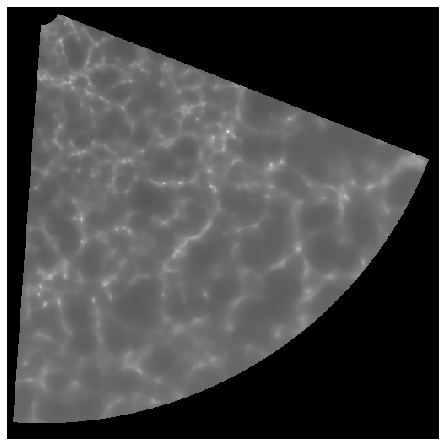

In [14]:
tvscale( vol_den[511,:,:]**0.1 )

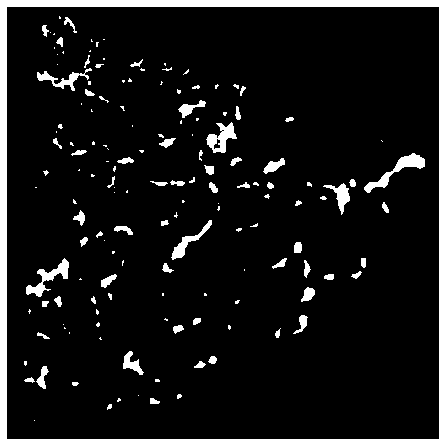

In [15]:
tvscale( (vol_den[511,:,:] > 3))

In [16]:
#--- Read SDSS galaxies
sdss = mrdfits('Data/DR7_FTU.fit')


/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = dat[1].data.field(col_name).flatten()
/Users/miguel/Develop/python_utils/Astro/astro_io.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

### Define map properties

In [17]:
mapp = {'x0':0.5, 'y0':0.0, 'z0':0.04, 'max_l':1024, 'H_o':73.0, 'c_l':299792.458}

### Read MANGA sample

In [18]:
FILE_CSV = '/Users/miguel/Science/Hector/Data/BSF_v5.1.csv'
PATH_INP = 'MANGA/SAMPLE/IMAGES/'
PATH_OUT = 'MANGA/SAMPLE/'
SUFF     = 'MANGA'

#FILE_CSV = '/Users/miguel/Science/Hector/Data/controlE_v5.1_20230719.csv'
#PATH_OUT = 'MANGA/CONTROL/'

manga = np.genfromtxt(FILE_CSV, delimiter=',', skip_header=1, dtype=None, encoding='utf-8')

print(str(len(manga)) + " datapoints")

44 datapoints


***
***
### Display galaxy sample
***

{'ra': 132.912768243, 'dec': 57.1074235568, 'z': 0.0256063, 'name': '10001-3702'}


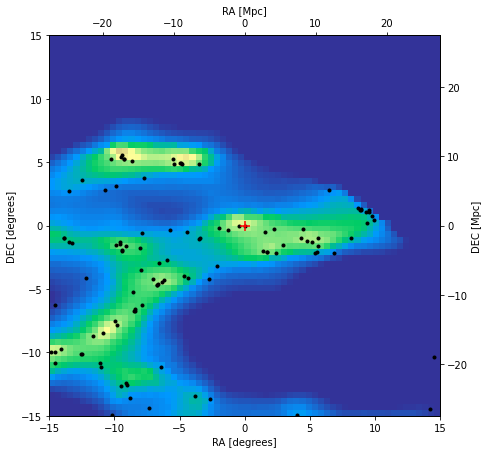

{'ra': 121.733213717, 'dec': 18.2226071136, 'z': 0.0160309, 'name': '10497-3703'}


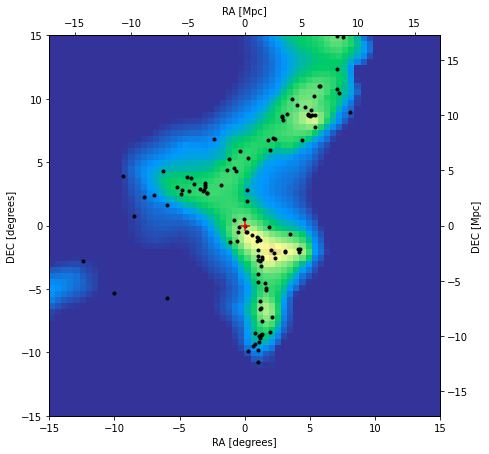

{'ra': 150.071302979, 'dec': 4.8887850018, 'z': 0.0132365, 'name': '10517-12704'}


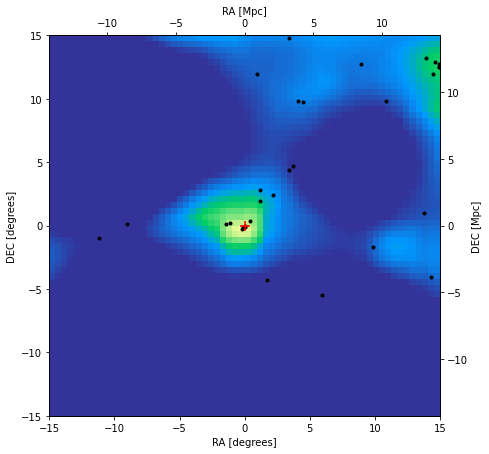

{'ra': 194.966486933, 'dec': 51.2121754672, 'z': 0.03519498, 'name': '11018-1902'}


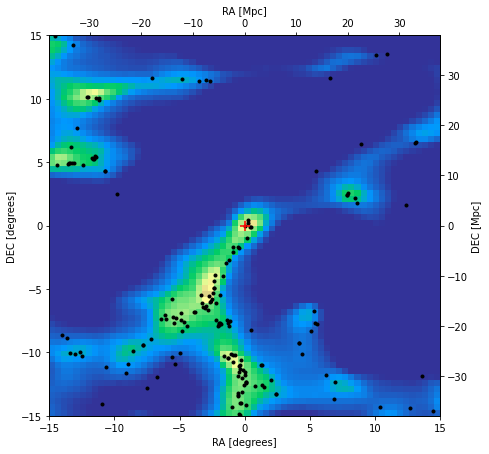

{'ra': 129.171011759, 'dec': 45.0969721629, 'z': 0.038232483, 'name': '11745-3703'}


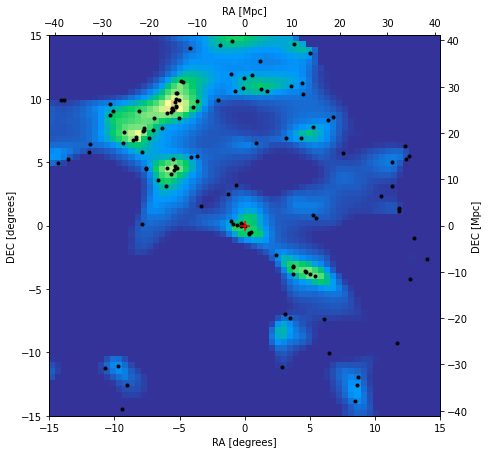

{'ra': 202.20397413, 'dec': 53.4429206757, 'z': 0.025356574, 'name': '11758-1901'}


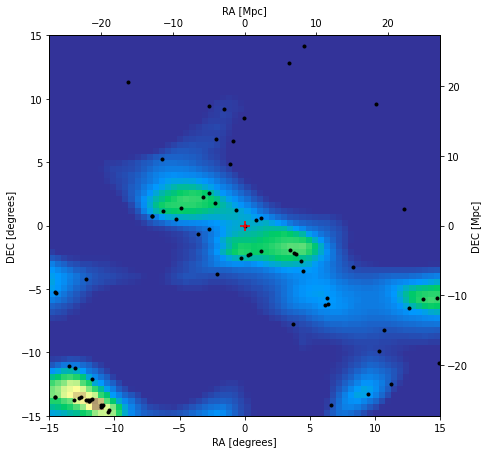

{'ra': 192.768551758, 'dec': 48.4085748066, 'z': 0.049425263, 'name': '11760-1902'}


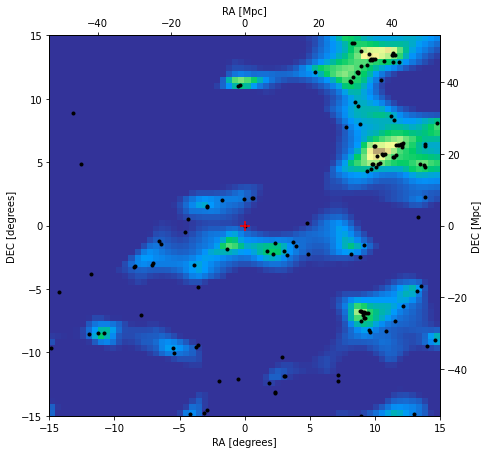

{'ra': 193.877108145, 'dec': 52.0604218621, 'z': 0.037693724, 'name': '11761-1902'}


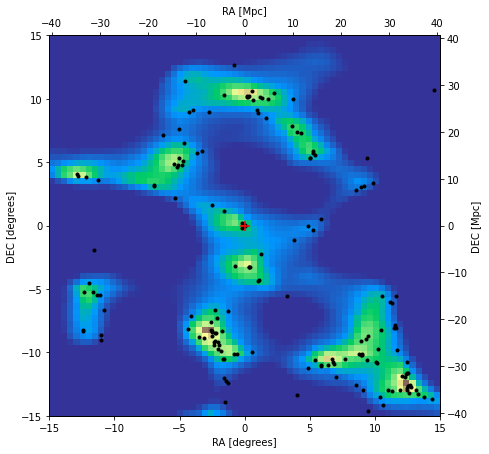

{'ra': 190.320043463, 'dec': 37.8241224038, 'z': 0.024401372, 'name': '11826-3704'}


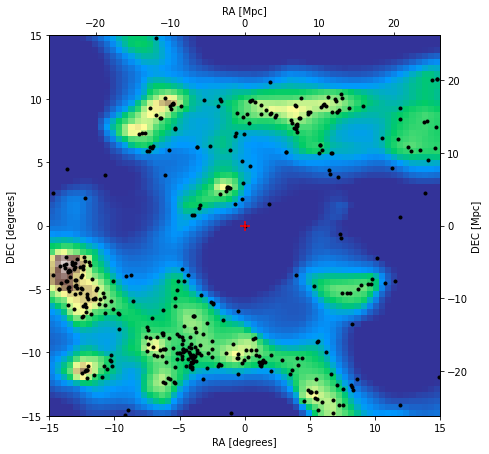

{'ra': 163.588576732, 'dec': 3.39578862595, 'z': 0.034925275, 'name': '11828-3704'}


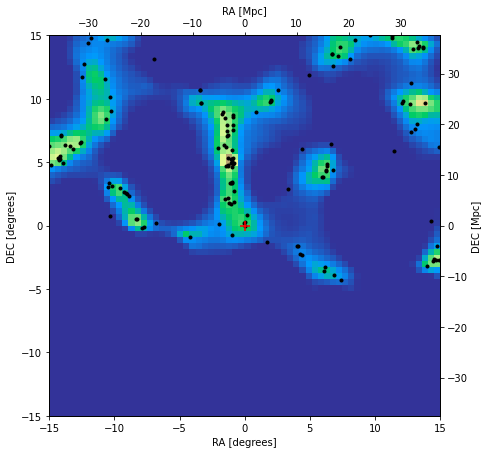

{'ra': 232.644086848, 'dec': 10.1811410348, 'z': 0.032972906, 'name': '11963-1901'}


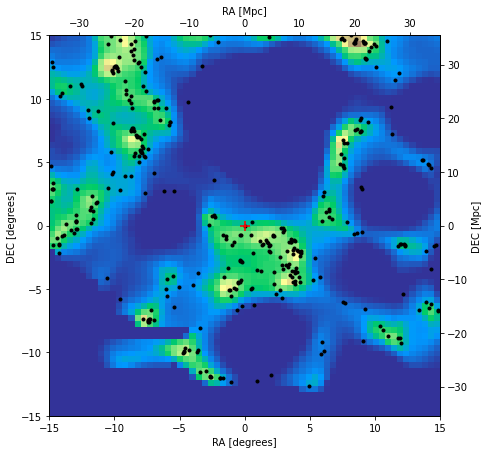

{'ra': 255.494175135, 'dec': 24.2364238364, 'z': 0.041152112, 'name': '11980-1901'}


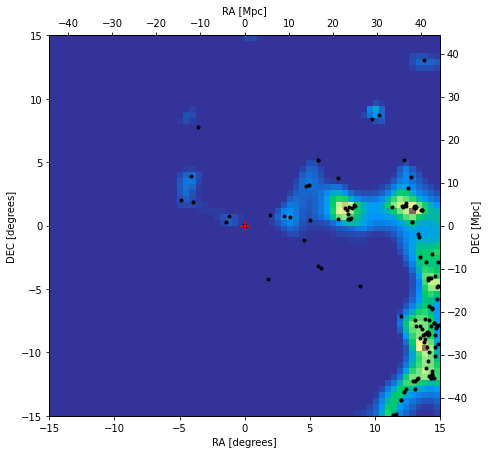

{'ra': 254.317499324, 'dec': 18.452642335, 'z': 0.03282385, 'name': '11981-1902'}


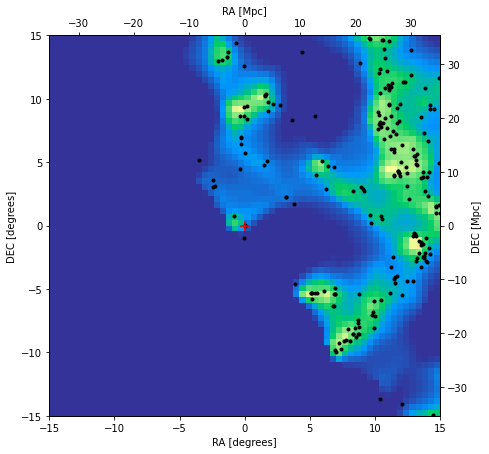

{'ra': 259.266780806, 'dec': 64.3399632955, 'z': 0.03506536, 'name': '11983-3703'}


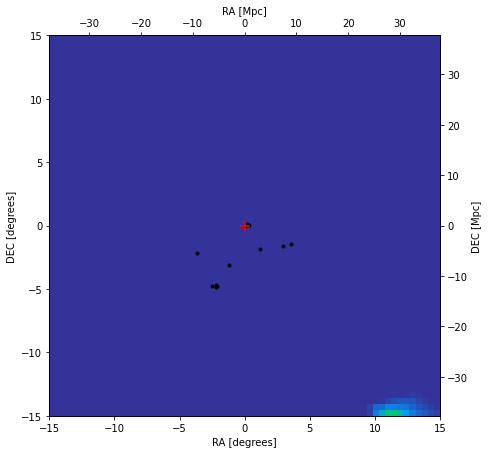

{'ra': 31.2701037754, 'dec': -0.711722748107, 'z': 0.04319104, 'name': '12080-6104'}


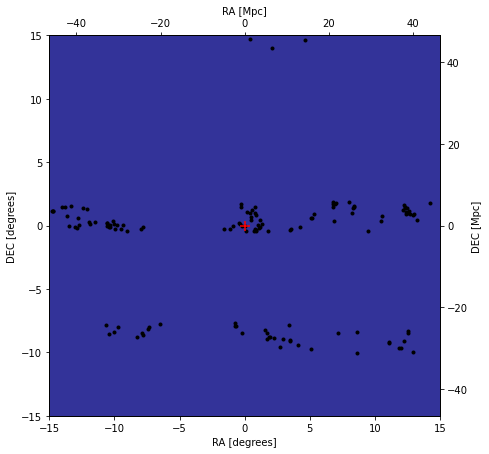

{'ra': 32.8898397854, 'dec': 13.9171267807, 'z': 0.0265066, 'name': '7993-1902'}


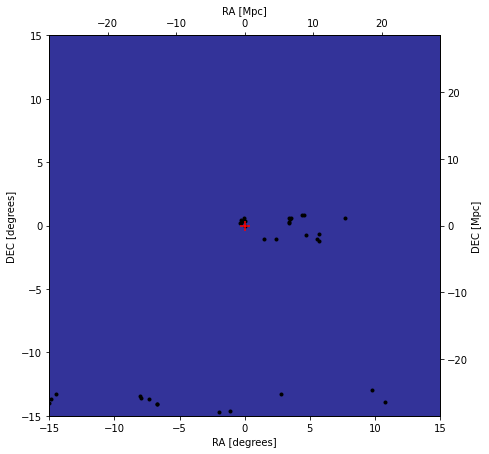

{'ra': 4.70333033859, 'dec': 14.7830526147, 'z': 0.0410546, 'name': '8088-1902'}


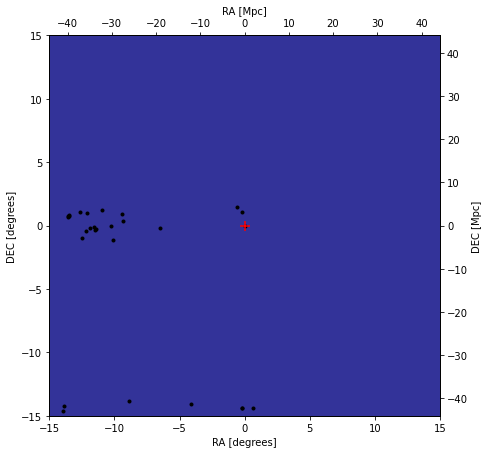

{'ra': 6.82394466351, 'dec': 15.9126171144, 'z': 0.0370928, 'name': '8089-1901'}


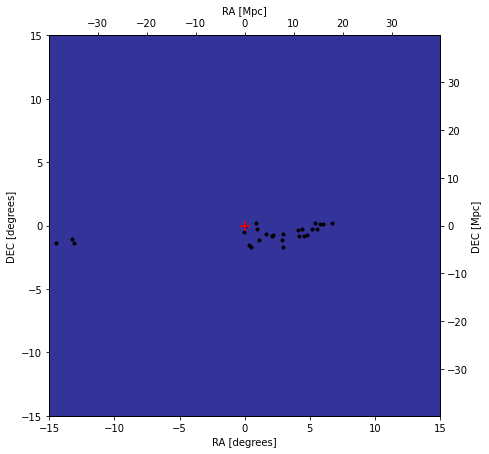

{'ra': 118.660223852, 'dec': 42.5441122846, 'z': 0.0318057, 'name': '8143-1901'}


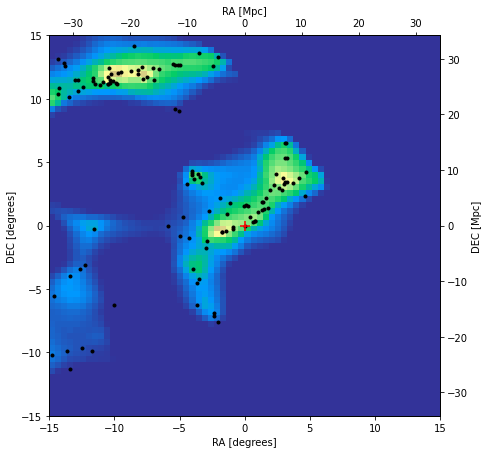

{'ra': 114.695391123, 'dec': 29.8912832677, 'z': 0.0978535, 'name': '8144-3702'}


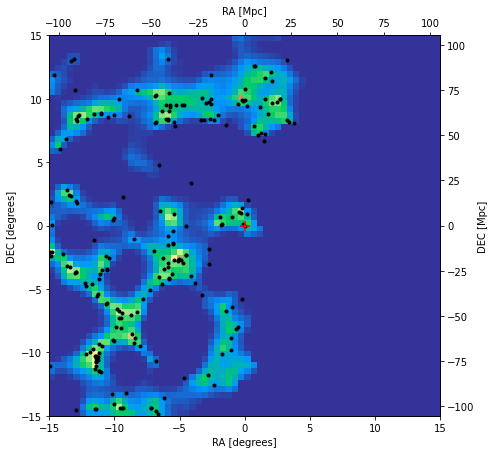

{'ra': 117.05386562, 'dec': 28.2250917233, 'z': 0.0270561, 'name': '8146-1901'}


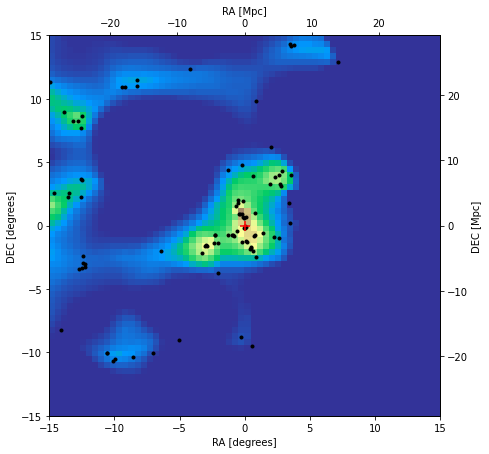

{'ra': 116.213915388, 'dec': 26.5790388255, 'z': 0.023827, 'name': '8147-1901'}


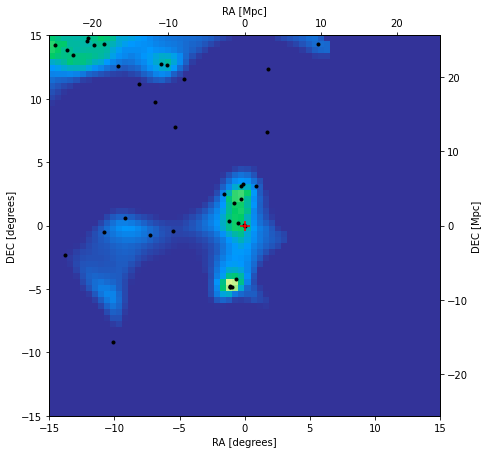

{'ra': 54.095960737, 'dec': -0.882664935104, 'z': 0.0235779, 'name': '8155-3703'}


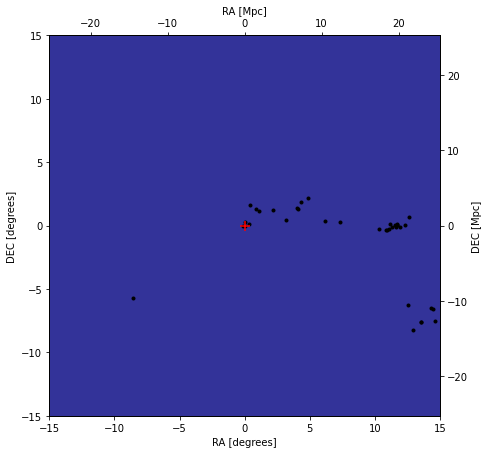

{'ra': 139.739960635, 'dec': 43.5005762984, 'z': 0.040052, 'name': '8250-3703'}


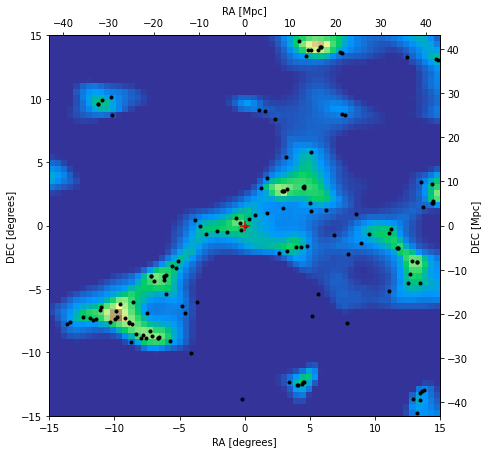

{'ra': 179.593305477, 'dec': 43.8152710678, 'z': 0.0699792, 'name': '8259-3704'}


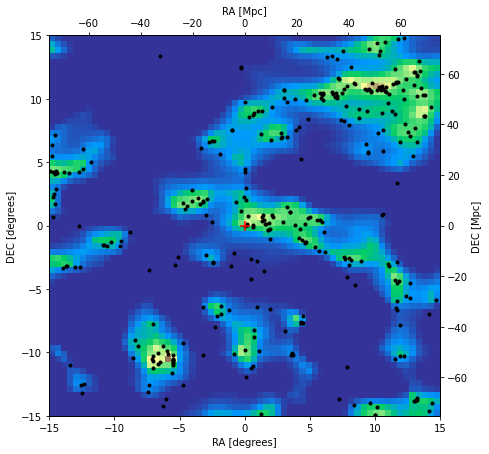

{'ra': 241.846680273, 'dec': 41.7089702164, 'z': 0.0180762, 'name': '8313-3703'}


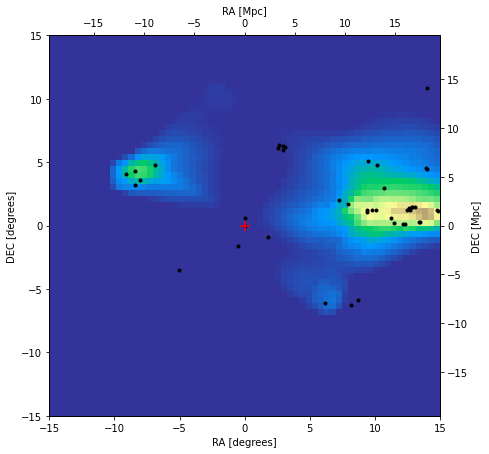

{'ra': 203.895344508, 'dec': 42.4021725079, 'z': 0.0629062, 'name': '8331-6101'}


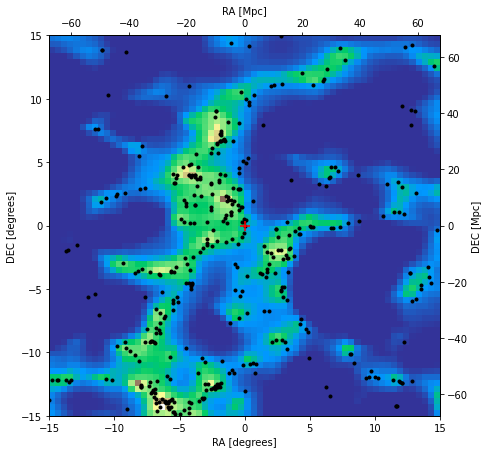

{'ra': 215.229240711, 'dec': 40.1210273909, 'z': 0.0175421, 'name': '8335-6101'}


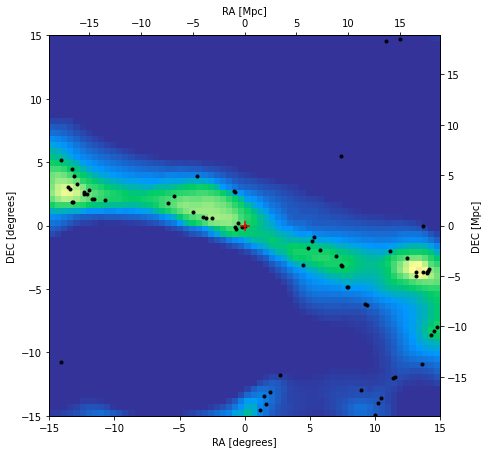

{'ra': 141.190236455, 'dec': 49.4448016737, 'z': 0.0163661, 'name': '8439-1901'}


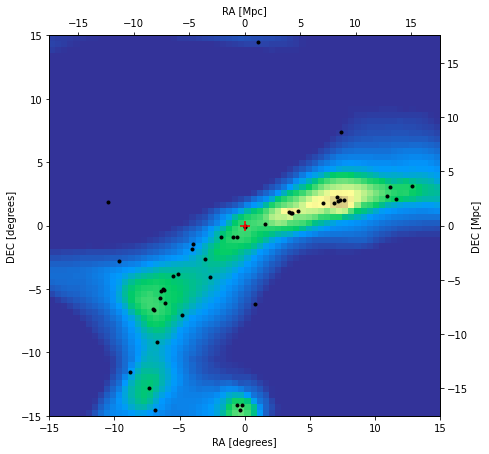

{'ra': 223.347448772, 'dec': 39.0704414113, 'z': 0.0315136, 'name': '8441-1902'}


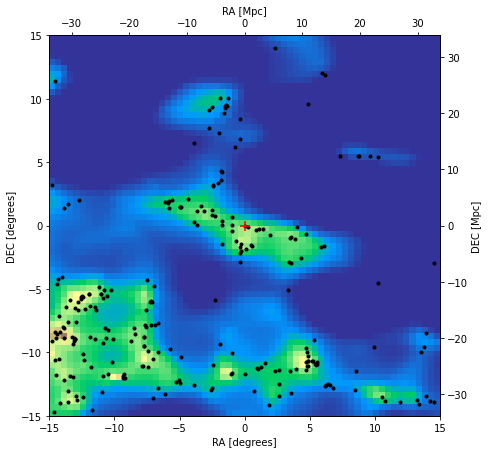

{'ra': 239.238058032, 'dec': 47.1332211828, 'z': 0.0196135, 'name': '8487-9101'}


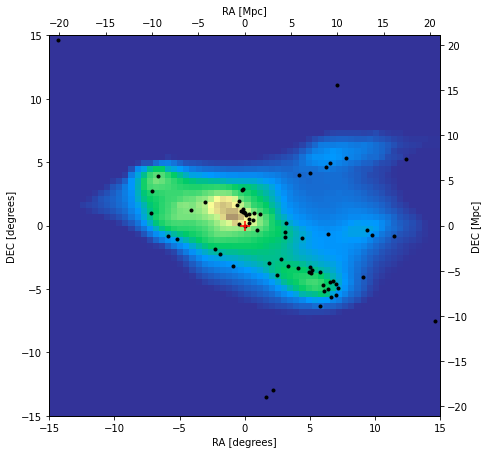

{'ra': 242.099727618, 'dec': 48.9445145619, 'z': 0.0443926, 'name': '8563-1902'}


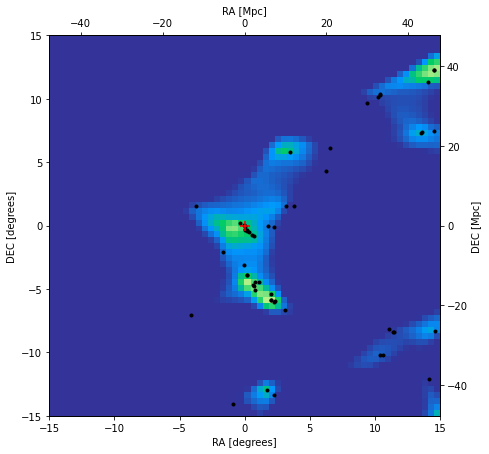

{'ra': 241.033211453, 'dec': 47.3496584526, 'z': 0.0421768, 'name': '8565-1902'}


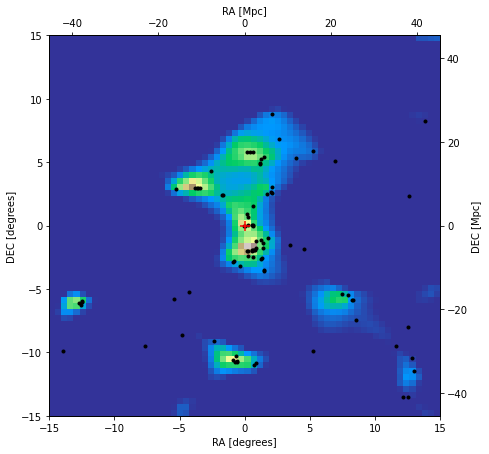

{'ra': 221.43798422, 'dec': 51.5808196479, 'z': 0.0296268, 'name': '8595-3703'}


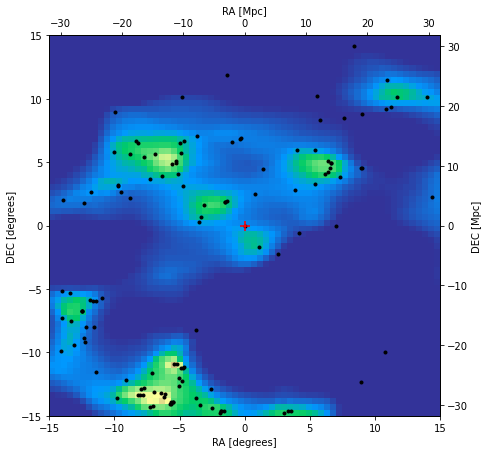

{'ra': 318.862286217, 'dec': 9.75781705378, 'z': 0.0702278, 'name': '8618-3704'}


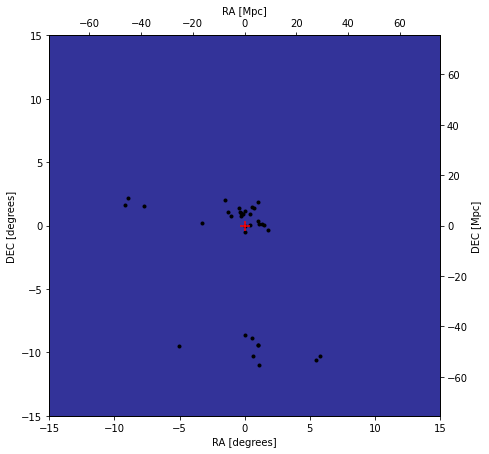

{'ra': 323.932154836, 'dec': 11.6507729216, 'z': 0.0454441, 'name': '8619-1902'}


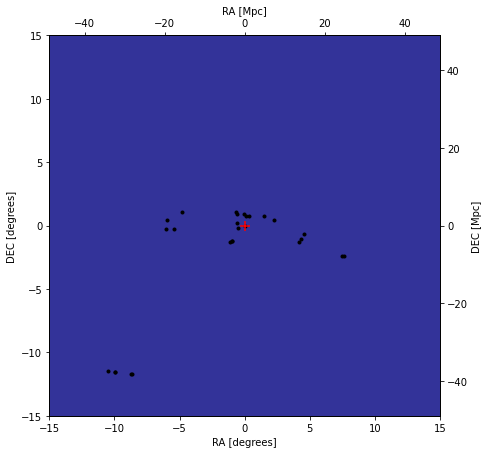

{'ra': 358.094461941, 'dec': -0.628759880529, 'z': 0.0226332, 'name': '8655-6101'}


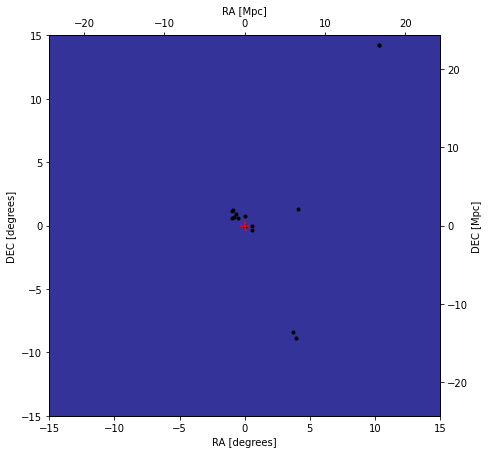

{'ra': 126.002477593, 'dec': 51.5404793547, 'z': 0.0812156, 'name': '8722-1901'}


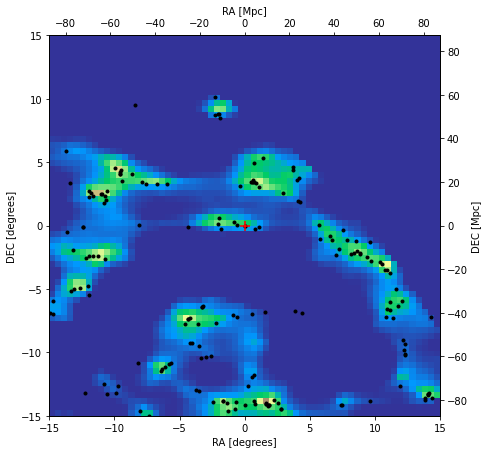

{'ra': 54.904965246, 'dec': -5.63293280732, 'z': 0.0209115, 'name': '8727-3701'}


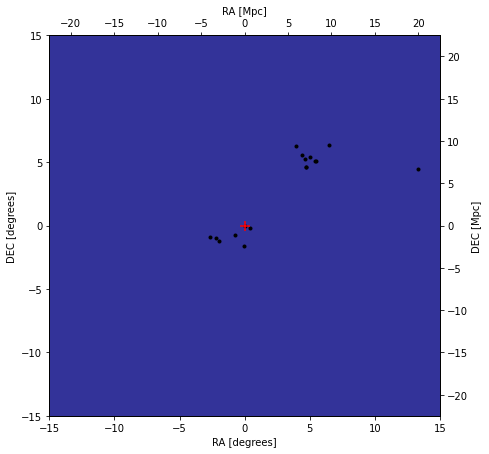

{'ra': 118.809562726, 'dec': 33.3532344702, 'z': 0.0822961, 'name': '8977-6104'}


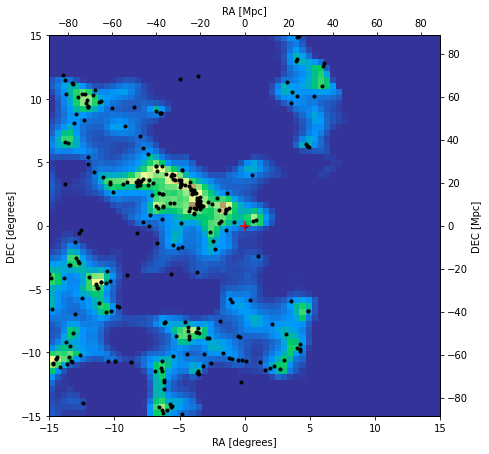

{'ra': 188.084043103, 'dec': 36.5133639493, 'z': 0.0227295, 'name': '8981-3704'}


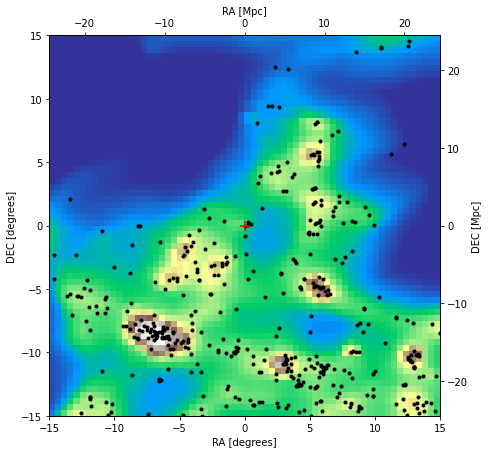

{'ra': 246.487237926, 'dec': 41.5220653861, 'z': 0.0427184, 'name': '9029-1902'}


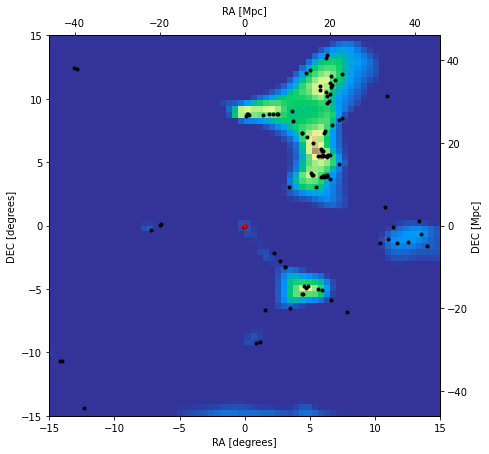

{'ra': 245.859250212, 'dec': 22.4857070018, 'z': 0.0375206, 'name': '9050-6102'}


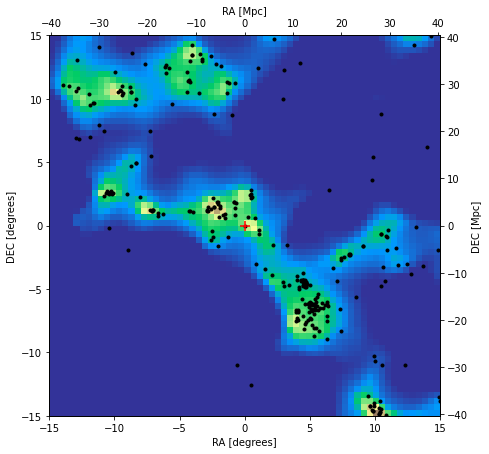

{'ra': 123.10611, 'dec': 37.730217, 'z': 0.0385007, 'name': '9183-12705'}


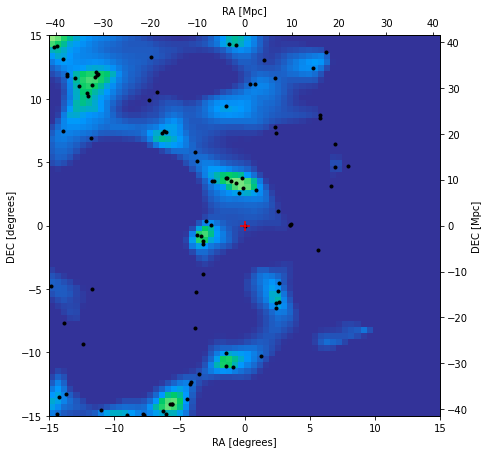

In [64]:
c_l       = 300000.0

ra_delta  = 30
dec_delta = 30
z_delta   = 0.02


for i in range(len(manga)):
#for i in range(20):
    
    gal_i = i
    target = {'ra':manga[gal_i][1], 'dec':manga[gal_i][2], 'z':manga[gal_i][3], 'name':manga[gal_i][7]}
    
    #if target['dec'] > 20: continue
    
    #----------------------------------------
    # RADEC
    #----------------------------------------
    ima = get_reds_slice_simple(vol_den, interp, target, 
                            ra_delta=ra_delta, dec_delta=dec_delta, n_ra=64, n_dec=64,mapp=mapp)

    x1 = -ra_delta/2
    x2 =  ra_delta/2
    y1 = -dec_delta/2
    y2 =  dec_delta/2

    
    plt.rcParams['figure.figsize'] = [7,7]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax3 = ax2.twinx()

     #--- plot SDSS galaxies
    val_sdss = np.where( (sdss['ra']     > target['ra'] -ra_delta/2 ) * (sdss['ra']     < target['ra'] +ra_delta/2 ) *
                         (sdss['dec']    > target['dec']-dec_delta/2) * (sdss['dec']    < target['dec']+dec_delta/2) *
                         (sdss['spec_z'] > target['z']  -z_delta/60) * (sdss['spec_z'] < target['z']  +z_delta/60))[0]
    ax1.scatter(target['ra']-sdss['ra'][val_sdss], sdss['dec'][val_sdss] - target['dec'], marker='.', color='black')


    ax1.set_xlim(-ra_delta/2, ra_delta/2)
    ax1.set_ylim(-dec_delta/2,dec_delta/2)
    ax1.set_xlabel('RA [degrees]')
    ax1.set_ylabel('DEC [degrees]')

    ima = np.log10(ima+0.001)
    ima = np.fliplr(ima)
    im = ax1.imshow(ima, origin='lower', aspect='auto', cmap='terrain',extent=[x1,x2,y1,y2],vmin=np.log10(0.5), vmax=3)

    #--- Upper axis
    ax2.set_xlim(-deg_Mpc(ra_delta/2, target['z'], mapp['H_o']), deg_Mpc(ra_delta/2, target['z'], mapp['H_o']))
    ax2.set_xlabel('RA [Mpc]')

    ax3.set_ylim(-deg_Mpc(dec_delta/2, target['z'], mapp['H_o']), deg_Mpc(dec_delta/2, target['z'], mapp['H_o']))
    ax3.set_ylabel('DEC [Mpc]')

    #--- Mark galaxy
    plt.scatter(0,0, color='red', marker='+', s=100)
    
    print(target)
        
    #plt.savefig(PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_RADEC.png', bbox_inches='tight')

    plt.show()
    



In [33]:
len(val_sdss)

3188

In [ ]:
c_l       = 300000.0

ra_delta  = 30
dec_delta = 30
z_delta   = 0.02


#for i in range(len(manga)):
for i in range(2):
    
    gal_i = i
    target = {'ra':manga[gal_i][1], 'dec':manga[gal_i][2], 'z':manga[gal_i][3], 'name':manga[gal_i][7]}
    
    #----------------------------------------
    # RADEC
    #----------------------------------------
    ima = get_reds_slice_simple(vol_den, interp, target, 
                            ra_delta=ra_delta, dec_delta=dec_delta, n_ra=64, n_dec=64,mapp=mapp)

    x1 = -ra_delta/2
    x2 =  ra_delta/2
    y1 = -dec_delta/2
    y2 =  dec_delta/2

    plt.rcParams['figure.figsize'] = [7,7]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax3 = ax2.twinx()

    ax1.set_xlabel('RA [degrees]')
    ax1.set_ylabel('DEC [degrees]')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)

    ima = np.log10(ima+0.001)
    ima = np.fliplr(ima)
    im = ax1.imshow(ima, origin='lower', aspect='auto', cmap='terrain',extent=[x1,x2,y1,y2],vmin=np.log10(0.5), vmax=3)

    #--- Upper axis
    ax2.set_xlim(-deg_Mpc(ra_delta/2, target['z'], mapp['H_o']), deg_Mpc(ra_delta/2, target['z'], mapp['H_o']))
    ax2.set_xlabel('RA [Mpc]')

    ax3.set_ylim(-deg_Mpc(dec_delta/2, target['z'], mapp['H_o']), deg_Mpc(dec_delta/2, target['z'], mapp['H_o']))
    ax3.set_ylabel('DEC [Mpc]')

    #--- Mark galaxy
    plt.scatter(0,0, color='red', marker='+', s=100)
    
    plt.savefig(PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_RADEC.png', bbox_inches='tight')

    plt.show()
    
    
    #----------------------------------------
    # RA-Z
    #----------------------------------------

    n_RA = 64
    PA   = 0

    ima = get_PA_slice(vol_den=vol_den, interp=interp, target=target, PA=PA, 
                       ra_delta=ra_delta, reds_delta=z_delta, n_ra=n_RA, n_reds=n_RA, mapp=mapp)

    # https://stackoverflow.com/questions/69631851/cartesian-zoom-with-polar-plot-in-python
    ang = np.radians(ra_delta/2)

    # Create radial and angular array
    tt = np.linspace(-ang, ang,n_RA)
    r1 = z_Mpc(target['z']-z_delta/2,mapp['H_o'])
    r2 = z_Mpc(target['z']+z_delta/2,mapp['H_o'])
    rr = np.linspace( r1, r2,  n_RA)

    #Create the figure
    f = plt.figure(figsize=(13,8))
    ax = plt.subplot(111, projection='polar')
    ax.set_rorigin(0)

    #Plot the data
    pcm = ax.pcolormesh(tt,rr,np.log10(ima+0.001),cmap = 'terrain',shading='nearest',vmin=np.log10(0.5), vmax=3)
    ax.set_xlim([-ang, ang])
    ax.set_ylim([r1,r2])

    ax.text(-ang*1.3, (r1+r2)/2.0, 'radius [Mpc]')

    #--- Mark galaxy
    plt.scatter(0,(r1+r2)/2.0, color='red', marker='+', s=100)

    plt.savefig(PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_RA-Z.png', bbox_inches='tight')

    plt.show()    
    
    #----------------------------------------
    # DEC-Z
    #----------------------------------------
    n_RA = 64
    PA   = 90

    ima = get_PA_slice(vol_den=vol_den, interp=interp, target=target, PA=PA, 
                       ra_delta=ra_delta, reds_delta=z_delta, n_ra=n_RA, n_reds=n_RA, mapp=mapp)

    # https://stackoverflow.com/questions/69631851/cartesian-zoom-with-polar-plot-in-python
    ang = np.radians(ra_delta/2)

    # Create radial and angular array
    tt = np.linspace(-ang, ang,n_RA)
    r1 = z_Mpc(target['z']-z_delta/2,mapp['H_o'])
    r2 = z_Mpc(target['z']+z_delta/2,mapp['H_o'])
    rr = np.linspace( r1, r2,  n_RA)

    #Create the figure
    f = plt.figure(figsize=(13,8))
    ax = plt.subplot(111, projection='polar')
    ax.set_rorigin(0)

    #Plot the data
    pcm = ax.pcolormesh(tt,rr,np.log10(ima+0.001),cmap = 'terrain',shading='nearest',vmin=np.log10(0.5), vmax=3)
    ax.set_xlim([-ang, ang])
    ax.set_ylim([r1,r2])

    #--- Mark galaxy
    plt.scatter(0,(r1+r2)/2.0, color='red', marker='+', s=100)

    plt.savefig(PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_DEC-Z.png', bbox_inches='tight')

    plt.show()
    
    
    #----------------------------------------
    # COMPOSITE
    #----------------------------------------
    FILE_RADEC = PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_RADEC.png'
    FILE_RAZ   = PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_RA-Z.png'
    FILE_DEZ   = PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_DEC-Z.png'
    FILE_CB    = 'colorbar.png'

    Figure("10cm", "10cm",
            Panel(
                  Image(5,5, FILE_DEZ),
                  Text('MANGA '+str(gal_i).zfill(3), 1, 1, size=0.25).move(-0.85,-0.5)
                 ).move(0, 0),
            Panel(
                  Image(5,5, FILE_RADEC),
                 ).move(5, 0),
            Panel(
                  Image(5,5, FILE_RAZ),
                 ).rotate(-90).move(5, 10),
            Panel(
                  Image(5,5, FILE_CB),
                 ).move(0, 5)
            ).save(PATH_OUT+SUFF+'-'+str(gal_i).zfill(4)+'COMPOSITE-RA-DEC-Z.svg')
    
    #--------------------------------------------------------------------
    # SPHERES
    #--------------------------------------------------------------------
    for w in range(1,6):

        radius = w*5
        print('radius = ', radius)

        ima = get_sphere_simple(vol_den, interp, target=target, 
                                n_lon=256, n_lat=128, radius=radius, mapp=mapp)

        render_aitoff(np.log10(ima+0.001), 100,np.log10(0.5), 3, filename=PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_SPH-'+str(radius).zfill(2)+'.png')

    #----------------------------------------
    # COMPOSITE
    #----------------------------------------
    Figure("10cm", "5cm",
            Panel(
                  Image(5,2.5, PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_SPH-05.png'),
                  Text(SUFF+' '+str(gal_i).zfill(3), 1, 1, size=0.2).move(3.3,-0.6),
                  Text('5 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(0,0),
            Panel(
                  Image(5,2.5, PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_SPH-10.png'),
                  Text('10 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(5, 0),
            Panel(
                  Image(5,2.5, PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_SPH-15.png'),
                  Text('15 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(0, 2.5),
            Panel(
                  Image(5,2.5, PATH_INP+SUFF+'-'+str(gal_i).zfill(4)+'_SPH-20.png'),
                  Text('20 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(5, 2.5)
            ).save(PATH_OUT+SUFF+'-'+str(gal_i).zfill(4)+'COMPOSITE-SPHERE.svg')


 


In [ ]:
for i in range(2):
    gal_i = i
    #----------------------------------------
    # COMPOSITE
    #----------------------------------------
    Figure("10cm", "5cm",
            Panel(
                  Image(5,2.5, PATH_INP+'MANGA-'+str(gal_i).zfill(4)+'_SPH-05.png'),
                  Text('MANGA '+str(gal_i).zfill(3), 1, 1, size=0.2).move(3.3,-0.6),
                  Text('5 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(0,0),
            Panel(
                  Image(5,2.5, PATH_INP+'MANGA-'+str(gal_i).zfill(4)+'_SPH-10.png'),
                  Text('10 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(5, 0),
            Panel(
                  Image(5,2.5, PATH_INP+'MANGA-'+str(gal_i).zfill(4)+'_SPH-15.png'),
                  Text('15 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(0, 2.5),
            Panel(
                  Image(5,2.5, PATH_INP+'MANGA-'+str(gal_i).zfill(4)+'_SPH-20.png'),
                  Text('20 Mpc', 1, 1, size=0.2).move(-0.6,1.3)
                 ).move(5, 2.5)
            ).save(PATH_OUT+'MANGA-'+str(gal_i).zfill(4)+'COMPOSITE-SPHERE.svg')
    

***

In [ ]:
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.8, 0.9, 0.05])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', label=r'Log $\delta + 1$', 
                               cmap='terrain', norm=mpl.colors.Normalize(np.log10(0.5), 3))

plt.savefig('colorbar', bbox_inches='tight')
plt.show()

***